In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import shutil
# 把olddir拷贝一份newdir
shutil.copytree('/content/drive/MyDrive/GNN', 'GNN')

'GNN'

In [3]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install dgl

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 7.9 MB 4.5 MB/s 
     |████████████████████████████████| 3.5 MB 27.2 MB/s 
     |████████████████████████████████| 2.5 MB 30.6 MB/s 
     |████████████████████████████████| 750 kB 43.0 MB/s 
     |████████████████████████████████| 407 kB 5.2 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=88845fc2ccdaa34beac6152d0911cfffaf3308c211a93dd65e9e4b3aeb2fbf73
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric
     |████████████████████████████████| 4.4 MB 5.1 MB/s 


In [4]:
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch.nn import Linear
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch

import os
import torch_geometric
from torch_geometric.data import DataLoader
# from torch_geometric.nn import GraphConv
import torch
from torch.nn import Parameter
from torch_geometric.nn.conv import MessagePassing

from torch_geometric.nn.inits import uniform
import pdb
root = 'GNN/data_used'
label_list = os.listdir(root)
from torch_geometric.utils import dense_to_sparse
from torch_geometric.data import Data


In [5]:

class_dict = {
    "HC": 0,
    "ASD": 1,
}
threshold = 0.2
data_processed = []
for label_files in label_list:
    label = torch.LongTensor([class_dict[label_files]])
    listd = os.listdir(os.path.join(root, label_files))
    for files in listd:
        subj_fc_dir = os.path.join(root, label_files, files)
        subj_mat_fc = np.loadtxt(subj_fc_dir)[:176, :90]
        #print("reading data " + subj_fc_dir)
        subj_mat_fc_adj = np.corrcoef(np.transpose(subj_mat_fc))  #90*90--correlation coefficient
        subj_mat_fc_adj = subj_mat_fc_adj - np.diag(np.diag(subj_mat_fc_adj))
        #take the upper triangle and compute the threshold
        subj_fc_adj_up = subj_mat_fc_adj[np.triu_indices(90, k=1)]
        subj_fc_adj_list = subj_fc_adj_up.reshape((-1))
        thindex = int(threshold * subj_fc_adj_list.shape[0])
        thremax = subj_fc_adj_list[subj_fc_adj_list.argsort()[-1 * thindex - 1]]  #
        #avoiding Nan
        subj_fc_adj_t = np.zeros((90, 90))
        subj_fc_adj_t[subj_mat_fc_adj > thremax] = 1
        subj_mat_fc_adj = subj_fc_adj_t
        fcedge_index, _ = dense_to_sparse(torch.from_numpy(subj_mat_fc_adj.astype(np.int16)))

        subj_mat_fc_list = subj_mat_fc.reshape((-1))
        subj_mat_fc_new = (subj_mat_fc - min(subj_mat_fc_list)) / (
                max(subj_mat_fc_list) - min(subj_mat_fc_list))
        # subj_mat_fc_new = (subj_mat_fc - np.mean(subj_mat_fc, axis=0, keepdims=True)) / np.std(subj_mat_fc, axis=0, keepdims=True)

        subj_mat_fc_new = np.transpose(subj_mat_fc_new)  #90*176

        rowsum = np.array(subj_mat_fc_adj.sum(1))  #row sum #90,
        N = np.diag(rowsum)  #90*90
        degree_C_BOLD = np.concatenate((N, subj_mat_fc_new), 1)  #90*266
        # print(subj_mat_fc_adj)
        # BOLD_C_degree=np.concatenate((subj_mat_fc_new,N),1)
        ###one-hot###
        # subj_mat_fc_new=np.eye(args.num_nodes)
        data_processed.append(
            Data(x=torch.from_numpy(degree_C_BOLD).float(), edge_index=fcedge_index, y=torch.tensor(label)))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [6]:
import random
random.seed(1111)
random.shuffle(data_processed)
data_processed[:5]  #len:618;

[Data(x=[90, 266], edge_index=[2, 1602], y=[1]),
 Data(x=[90, 266], edge_index=[2, 1602], y=[1]),
 Data(x=[90, 266], edge_index=[2, 1602], y=[1]),
 Data(x=[90, 266], edge_index=[2, 1602], y=[1]),
 Data(x=[90, 266], edge_index=[2, 1602], y=[1])]

In [7]:
from sklearn.metrics import confusion_matrix
def confusion(g_turth,predictions):
    # print('g_truth: ', g_turth)
    # print('pred: ', predictions)
    # print('confusion_matrix: ', confusion_matrix(g_turth,predictions).ravel())
    tn, fp, fn, tp = confusion_matrix(g_turth,predictions, labels=[0, 1]).ravel()
    accuracy = (tp+tn)/(tp+fp+tn+fn)
    sensitivity = tp/(tp+fn)
    specificty = tn/(tn+fp)
    return accuracy, sensitivity, specificty

In [8]:

class GraphConv(MessagePassing):
    def __init__(self, in_channels, out_channels, aggr='mean', bias=True,
                 **kwargs):
        super(GraphConv, self).__init__(aggr=aggr, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.weight = Parameter(torch.Tensor(in_channels, out_channels)).to(device)
        self.lin = torch.nn.Linear(in_channels, out_channels, bias=bias).to(device)

        self.reset_parameters()

    def reset_parameters(self):
        uniform(self.in_channels, self.weight)
        self.lin.reset_parameters()

    def forward(self, x, edge_index, x_cen):
        h = torch.matmul(x, self.weight)
        aggr_out = self.propagate(edge_index, size=None, h=h, edge_weight=None)
        return (aggr_out + self.lin(x_cen)).to(device)

    def message(self, h_j):
        return h_j

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels,
                                   self.out_channels)


In [9]:
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(266, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        # self.conv4 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)

    def forward(self, x0, edge_index, edge_index_b, x0_b, lam, batch):
        x1 = self.conv1(x0, edge_index, x0)
        x1_b = self.conv1(x0_b, edge_index, x0_b)
        x1 = x1.tanh()
        x1_b = x1_b.tanh()
        x1 = F.dropout(x1, p=0.5, training=self.training)
        x1_b = F.dropout(x1_b, p=0.5, training=self.training)

        x2 = self.conv2(x1, edge_index, x1)
        x2_b = self.conv2(x1_b, edge_index, x1_b)
        x2 = x2.tanh()
        x2_b = x2_b.tanh()
        x2 = F.dropout(x2, p=0.5, training=self.training)
        x2_b = F.dropout(x2_b, p=0.5, training=self.training)

        # x0_mix = x0 * lam + x0_b * (1 - lam)

        # new_x1 = self.conv1(x0, edge_index, x0_mix)
        # new_x1_b = self.conv1(x0_b, edge_index_b, x0_mix)
        # new_x1 = F.relu(new_x1)
        # new_x1_b = F.relu(new_x1_b)

        # x1_mix = new_x1 * lam + new_x1_b * (1 - lam)
        # x1_mix = F.dropout(x1_mix, p=0.4, training=self.training)

        # new_x2 = self.conv2(x1, edge_index, x1_mix)
        # new_x2_b = self.conv2(x1_b, edge_index_b, x1_mix)
        # new_x2 = F.relu(new_x2)
        # new_x2_b = F.relu(new_x2_b)

        # x2_mix = new_x2 * lam + new_x2_b * (1 - lam)
        # x2_mix = F.dropout(x2_mix, p=0.4, training=self.training)

        # new_x3 = self.conv3(x2, edge_index, x2_mix)
        # new_x3_b = self.conv3(x2_b, edge_index_b, x2_mix)
        # new_x3 = F.relu(new_x3)
        # new_x3_b = F.relu(new_x3_b)

        # x3_mix = new_x3 * lam + new_x3_b * (1 - lam)
        # x3_mix = F.dropout(x3_mix, p=0.4, training=self.training)

        

        x3_ = global_mean_pool(x2, batch)
        x3b_ = global_mean_pool(x2_b, batch)
        x3_mix = x3_ * lam + x3b_ * (1-lam)

        x = x3_mix

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x


In [10]:
import copy
def idNode(data, id_new_value_old):
    data = copy.deepcopy(data)
    data.x = None
    data.y[data.val_id] = -1
    data.y[data.test_id] = -1
    data.y = data.y[id_new_value_old]

    data.train_id = None
    data.test_id = None
    data.val_id = None

    id_old_value_new = torch.zeros(id_new_value_old.shape[0], dtype = torch.long)
    id_old_value_new[id_new_value_old] = torch.arange(0, id_new_value_old.shape[0], dtype = torch.long)
    row = data.edge_index[0]
    col = data.edge_index[1]
    row = id_old_value_new[row]
    col = id_old_value_new[col]
    data.edge_index = torch.stack([row, col], dim=0)

    return data

# def shuffleData(data):
#     data = copy.deepcopy(data)
#     id_new_value_old = np.arange(data.num_nodes)
#     train_id_shuffle = copy.deepcopy(data.train_id)
#     np.random.shuffle(train_id_shuffle)
#     id_new_value_old[data.train_id] = train_id_shuffle
#     data = idNode(data, id_new_value_old)
#
#     return data, id_new_value_old

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
def train(model, optimizer, criterion, train_loader, mixup):
    model.train()

    if mixup:
        lam = np.random.beta(4.0, 4.0)
    else:
        lam = 1.0
    for data in train_loader:
        optimizer.zero_grad()
        data_b = copy.deepcopy(data)
        random.shuffle(data_b)
        data.to(device)
        data_b.to(device)
        out = model(data.x.to(device), data.edge_index.to(device), data_b.edge_index.to(device), data_b.x.to(device), lam, data.batch.to(device))
        loss = criterion(out, data.y)

        loss.backward()
        optimizer.step()

def test(model, loader):
    model.eval()

    accuracy,sensitivity,specificty = 0, 0, 0
    for data in loader:                            # batch iteration over the test set dataset
        data_b = copy.deepcopy(data)
        random.shuffle(data_b)
        data.to(device)
        data_b.to(device)
        out = model(data.x.to(device), data.edge_index.to(device), data.edge_index.to(device), data_b.x.to(device), 1, data.batch.to(device)) # 一次前向传播
        pred = out.argmax(dim=1)                         # category with the highest probability of use
        accuracy,sensitivity,specificty = confusion(g_turth=data.y.cpu(), predictions=pred.cpu())
    return accuracy,sensitivity,specificty

cuda


In [12]:
def get_loader_info(loader, name):
    print(name)
    for step, data in enumerate(loader):
        print(f'Step {step + 1}:')
        print('=======')
        print(f'Number of graphs in the current batch: {data.num_graphs}')
        print(data)
        print()

In [13]:
def get_k_fold_data(k, i, dataset):
    # return the training and test data required for the i-th fold cross-validation, separated
    assert k > 1
    # print(len(dataset))
    fold_size = len(dataset) // k  # Number of pieces per copy: total number of data items/number of folds (rounded down)

    dataset_train = None
    dataset_test = None
    for j in range(k):
        # idx = slice(j * fold_size, (j + 1) * fold_size)  # slice(start,end,step)切片函数 得到测试集的索引
        # print(idx)
        # X_part, y_part = X[idx, :], y[idx]
        dataset_part = dataset[j * fold_size : (j + 1) * fold_size]
        # can only slice the first dim
        if j == i:  # i-th fold is test
            dataset_test = dataset_part
        elif dataset_train is None:
            dataset_train = dataset_part
        else:
            dataset_train += dataset_part # concat other folds, only for the first dim
    return dataset_train, dataset_test

In [14]:
import matplotlib.pyplot as plt
def myplot(x_data, y_data, y_data2, y_data3, k, mod, m):
    ln1, = plt.plot(x_data,y_data,color='red',linewidth=2.0,linestyle='-')
    ln2, = plt.plot(x_data,y_data2,color='blue',linewidth=2.0,linestyle='-')
    ln3, = plt.plot(x_data,y_data3,color='green',linewidth=2.0,linestyle='-')


    plt.title(m + ' ' + mod + " fold: " + str(k))

    plt.legend(handles=[ln1,ln2,ln3],labels=['Acc','Sensitivity', 'Specificty'])

    ax = plt.gca()
    ax.spines['right'].set_color('none')  # set the right border attribute to none and do not display it
    ax.spines['top'].set_color('none')    # set the top border attribute to none and do not display it
    plt.savefig('GNN/img/'+mod+'{} fold.png'.format(k))
    plt.show()

In [15]:
def k_fold(k, dataset, num_epochs=200, learning_rate=0.0005, batch_size=128):
    for i in range(k):
        model = GNN(hidden_channels=128)
        model.to(device)
        train_dataset_, test_dataset = get_k_fold_data(k, i, dataset)
        train_dataset, valid_dataset = get_k_fold_data(k, i, train_dataset_)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
        # print(model)
        # get_loader_info(train_loader, 'train_loader')
        # get_loader_info(test_loader, 'test_loader')
        # get_loader_info(valid_loader, 'valid_loader')
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        criterion = torch.nn.CrossEntropyLoss()
        t_a_l = []
        t_sst_l = []
        t_sp_l = []
        v_a_l = []
        v_sst_l = []
        v_sp_l = []
        for epoch in range(1, num_epochs):
            train(model=model, optimizer=optimizer, criterion=criterion, train_loader=train_loader, mixup=True)
            train_accuracy, train_sensitivity, train_specificity = test(model=model, loader=train_loader)
            t_a_l.append(train_accuracy)
            t_sst_l.append(train_sensitivity)
            t_sp_l.append(train_specificity)
            valid_accuracy, valid_sensitivity, valid_specificity = test(model=model, loader=valid_loader)
            v_a_l.append(valid_accuracy)
            v_sst_l.append(valid_sensitivity)
            v_sp_l.append(valid_specificity)
            if epoch % 10 == 0:
              print(f'Fold: {i:01d}: Epoch: {epoch:03d}, Train Acc: {train_accuracy:.4f}, Train sensitivity: {train_sensitivity: .4f}, Train specificity: {train_specificity: .4f} \n\t\t\t\t\t Valid Acc: {valid_accuracy:.4f}, Valid sensitivity: {valid_sensitivity: .4f}, Valid specificity: {valid_specificity: .4f}')
        x = list(np.array(list(range(1,num_epochs))))
        # print(x)
        myplot(x_data=x, y_data=t_a_l, y_data2=t_sst_l, y_data3=t_sp_l, k=i, mod='train', m='GCN+mixup')
        myplot(x_data=x, y_data=v_a_l, y_data2=v_sst_l, y_data3=v_sp_l, k=i, mod='valid', m='GCN+mixup')
        test_accuracy, test_sensitivity, test_specificity = test(model=model, loader=test_loader)
        print(f'Fold: {i:01d}:  Test Acc: {test_accuracy:.4f}, Test sensitivity: {test_sensitivity: .4f}, Test specificity: {test_specificity: .4f}')

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold: 0: Epoch: 010, Train Acc: 0.5196, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.5926, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 0: Epoch: 020, Train Acc: 0.4902, Train sensitivity:  0.0189, Train specificity:  1.0000 
					 Valid Acc: 0.5926, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 0: Epoch: 030, Train Acc: 0.6176, Train sensitivity:  0.3125, Train specificity:  0.8889 
					 Valid Acc: 0.5926, Valid sensitivity:  0.1364, Valid specificity:  0.9062
Fold: 0: Epoch: 040, Train Acc: 0.6176, Train sensitivity:  0.5918, Train specificity:  0.6415 
					 Valid Acc: 0.5741, Valid sensitivity:  0.4545, Valid specificity:  0.6562
Fold: 0: Epoch: 050, Train Acc: 0.5882, Train sensitivity:  0.0476, Train specificity:  0.9667 
					 Valid Acc: 0.5926, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 0: Epoch: 060, Train Acc: 0.5784, Train sensitivity:  0.1458, Train specificity:  0.9630 
					 Valid Acc: 0.5370,

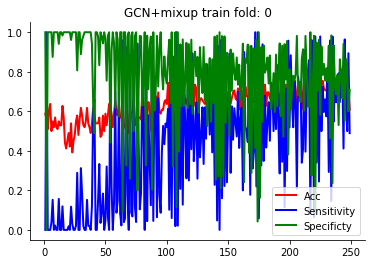

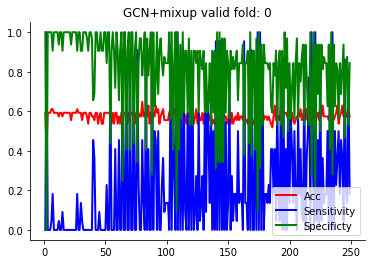

Fold: 0:  Test Acc: 0.6721, Test sensitivity:  0.5185, Test specificity:  0.7941


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold: 1: Epoch: 010, Train Acc: 0.4902, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.6296, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 1: Epoch: 020, Train Acc: 0.5392, Train sensitivity:  0.1818, Train specificity:  0.9574 
					 Valid Acc: 0.6111, Valid sensitivity:  0.2000, Valid specificity:  0.8529
Fold: 1: Epoch: 030, Train Acc: 0.5294, Train sensitivity:  0.8571, Train specificity:  0.2264 
					 Valid Acc: 0.4444, Valid sensitivity:  0.9000, Valid specificity:  0.1765
Fold: 1: Epoch: 040, Train Acc: 0.6667, Train sensitivity:  0.7400, Train specificity:  0.5962 
					 Valid Acc: 0.4259, Valid sensitivity:  0.6000, Valid specificity:  0.3235
Fold: 1: Epoch: 050, Train Acc: 0.5294, Train sensitivity:  0.7143, Train specificity:  0.4000 
					 Valid Acc: 0.4630, Valid sensitivity:  0.5500, Valid specificity:  0.4118
Fold: 1: Epoch: 060, Train Acc: 0.6961, Train sensitivity:  0.8800, Train specificity:  0.5192 
					 Valid Acc: 0.4444,

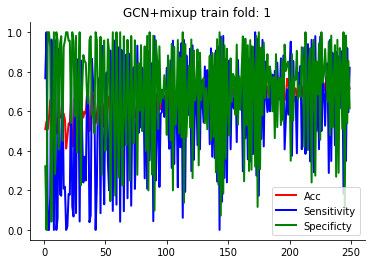

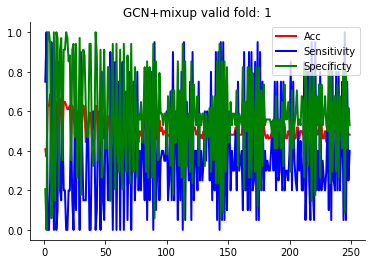

Fold: 1:  Test Acc: 0.5738, Test sensitivity:  0.6364, Test specificity:  0.5385


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold: 2: Epoch: 010, Train Acc: 0.5098, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.5741, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 2: Epoch: 020, Train Acc: 0.5000, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.5741, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 2: Epoch: 030, Train Acc: 0.6176, Train sensitivity:  0.2667, Train specificity:  0.8947 
					 Valid Acc: 0.5370, Valid sensitivity:  0.3478, Valid specificity:  0.6774
Fold: 2: Epoch: 040, Train Acc: 0.5588, Train sensitivity:  0.1373, Train specificity:  0.9804 
					 Valid Acc: 0.5926, Valid sensitivity:  0.0870, Valid specificity:  0.9677
Fold: 2: Epoch: 050, Train Acc: 0.6765, Train sensitivity:  0.3000, Train specificity:  0.9194 
					 Valid Acc: 0.5185, Valid sensitivity:  0.2174, Valid specificity:  0.7419
Fold: 2: Epoch: 060, Train Acc: 0.6765, Train sensitivity:  0.3333, Train specificity:  0.9474 
					 Valid Acc: 0.5556,

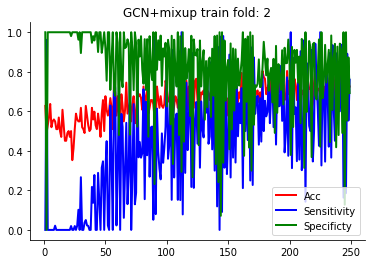

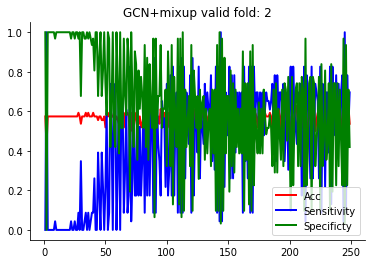

Fold: 2:  Test Acc: 0.4426, Test sensitivity:  0.3448, Test specificity:  0.5312


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold: 3: Epoch: 010, Train Acc: 0.5588, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.5556, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 3: Epoch: 020, Train Acc: 0.5098, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.5556, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 3: Epoch: 030, Train Acc: 0.6078, Train sensitivity:  0.0476, Train specificity:  1.0000 
					 Valid Acc: 0.5741, Valid sensitivity:  0.0417, Valid specificity:  1.0000
Fold: 3: Epoch: 040, Train Acc: 0.5196, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.5556, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 3: Epoch: 050, Train Acc: 0.5980, Train sensitivity:  0.0244, Train specificity:  0.9836 
					 Valid Acc: 0.5741, Valid sensitivity:  0.0417, Valid specificity:  1.0000
Fold: 3: Epoch: 060, Train Acc: 0.5980, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.5741,

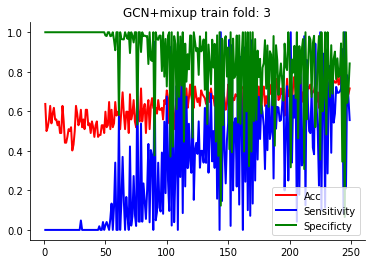

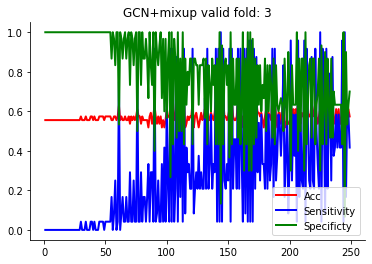

Fold: 3:  Test Acc: 0.5902, Test sensitivity:  0.5588, Test specificity:  0.6296


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold: 4: Epoch: 010, Train Acc: 0.5392, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.4815, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 4: Epoch: 020, Train Acc: 0.5000, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.4815, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 4: Epoch: 030, Train Acc: 0.6078, Train sensitivity:  0.0476, Train specificity:  1.0000 
					 Valid Acc: 0.4630, Valid sensitivity:  0.0000, Valid specificity:  0.9615
Fold: 4: Epoch: 040, Train Acc: 0.5098, Train sensitivity:  0.0196, Train specificity:  1.0000 
					 Valid Acc: 0.4815, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 4: Epoch: 050, Train Acc: 0.6569, Train sensitivity:  0.5682, Train specificity:  0.7241 
					 Valid Acc: 0.5370, Valid sensitivity:  0.5357, Valid specificity:  0.5385
Fold: 4: Epoch: 060, Train Acc: 0.6078, Train sensitivity:  0.0698, Train specificity:  1.0000 
					 Valid Acc: 0.4815,

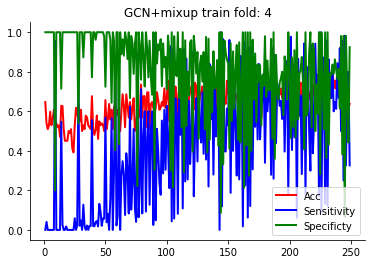

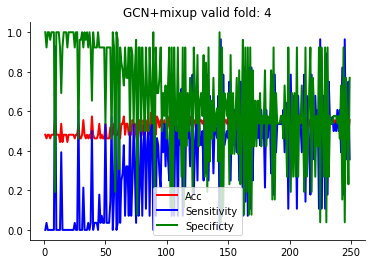

Fold: 4:  Test Acc: 0.6557, Test sensitivity:  0.1739, Test specificity:  0.9474


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold: 5: Epoch: 010, Train Acc: 0.5392, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.6111, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 5: Epoch: 020, Train Acc: 0.5196, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.6111, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 5: Epoch: 030, Train Acc: 0.6078, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.6111, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 5: Epoch: 040, Train Acc: 0.5000, Train sensitivity:  0.0192, Train specificity:  1.0000 
					 Valid Acc: 0.6111, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 5: Epoch: 050, Train Acc: 0.6471, Train sensitivity:  0.3556, Train specificity:  0.8772 
					 Valid Acc: 0.5926, Valid sensitivity:  0.2381, Valid specificity:  0.8182
Fold: 5: Epoch: 060, Train Acc: 0.6176, Train sensitivity:  0.0952, Train specificity:  0.9833 
					 Valid Acc: 0.6296,

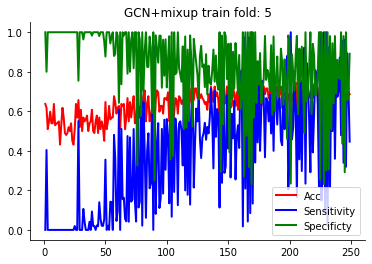

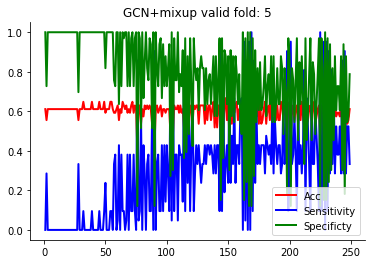

Fold: 5:  Test Acc: 0.4918, Test sensitivity:  0.3429, Test specificity:  0.6923


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold: 6: Epoch: 010, Train Acc: 0.5588, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.4444, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 6: Epoch: 020, Train Acc: 0.5490, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.4444, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 6: Epoch: 030, Train Acc: 0.6176, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.4444, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 6: Epoch: 040, Train Acc: 0.5294, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.4444, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 6: Epoch: 050, Train Acc: 0.5490, Train sensitivity:  0.0213, Train specificity:  1.0000 
					 Valid Acc: 0.4815, Valid sensitivity:  0.0667, Valid specificity:  1.0000
Fold: 6: Epoch: 060, Train Acc: 0.5980, Train sensitivity:  0.0238, Train specificity:  1.0000 
					 Valid Acc: 0.4444,

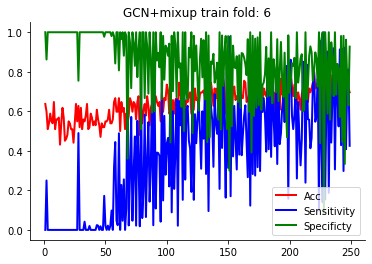

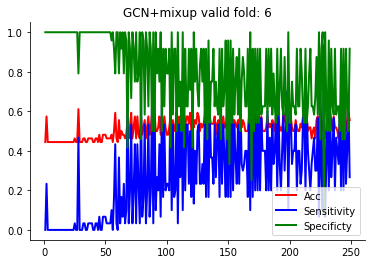

Fold: 6:  Test Acc: 0.5902, Test sensitivity:  0.3214, Test specificity:  0.8182


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold: 7: Epoch: 010, Train Acc: 0.5196, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.5000, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 7: Epoch: 020, Train Acc: 0.5588, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.5000, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 7: Epoch: 030, Train Acc: 0.6275, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.5000, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 7: Epoch: 040, Train Acc: 0.5588, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.5000, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 7: Epoch: 050, Train Acc: 0.5294, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.4815, Valid sensitivity:  0.0000, Valid specificity:  0.9630
Fold: 7: Epoch: 060, Train Acc: 0.6176, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.5000,

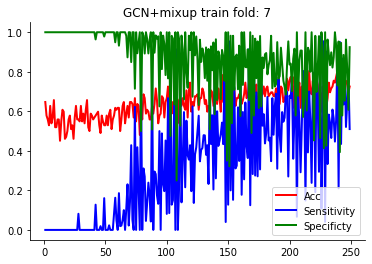

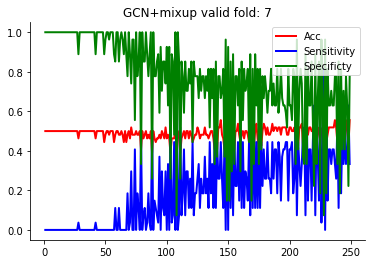

Fold: 7:  Test Acc: 0.4918, Test sensitivity:  0.2895, Test specificity:  0.8261


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold: 8: Epoch: 010, Train Acc: 0.4902, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.3333, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 8: Epoch: 020, Train Acc: 0.5784, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.3333, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 8: Epoch: 030, Train Acc: 0.5980, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.3333, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 8: Epoch: 040, Train Acc: 0.5294, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.3333, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 8: Epoch: 050, Train Acc: 0.5294, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.3333, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 8: Epoch: 060, Train Acc: 0.5686, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.3333,

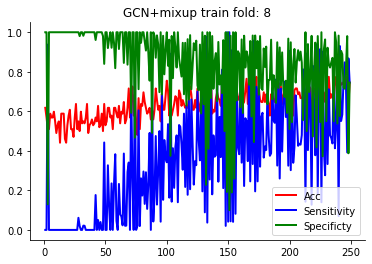

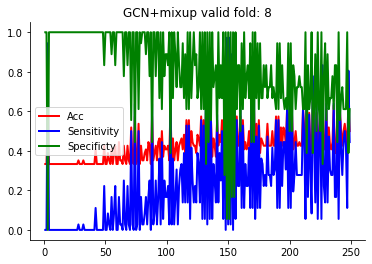

Fold: 8:  Test Acc: 0.5902, Test sensitivity:  0.7273, Test specificity:  0.5128


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold: 9: Epoch: 010, Train Acc: 0.4706, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.6667, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 9: Epoch: 020, Train Acc: 0.5980, Train sensitivity:  0.0698, Train specificity:  0.9831 
					 Valid Acc: 0.6852, Valid sensitivity:  0.1111, Valid specificity:  0.9722
Fold: 9: Epoch: 030, Train Acc: 0.5882, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.6667, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 9: Epoch: 040, Train Acc: 0.5000, Train sensitivity:  0.0192, Train specificity:  1.0000 
					 Valid Acc: 0.6667, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 9: Epoch: 050, Train Acc: 0.5392, Train sensitivity:  0.0612, Train specificity:  0.9811 
					 Valid Acc: 0.6667, Valid sensitivity:  0.0556, Valid specificity:  0.9722
Fold: 9: Epoch: 060, Train Acc: 0.6078, Train sensitivity:  0.1136, Train specificity:  0.9828 
					 Valid Acc: 0.6667,

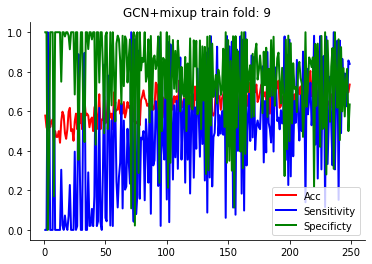

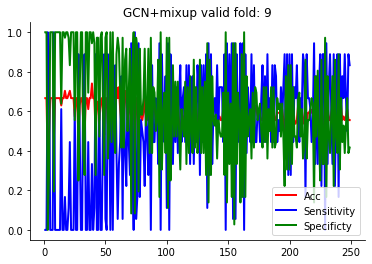

Fold: 9:  Test Acc: 0.5738, Test sensitivity:  0.5357, Test specificity:  0.6061


In [18]:
k_fold(10, dataset=data_processed, num_epochs=250)